In [1]:
from fastai.basics import *
from fastai.vision import models
from fastai.vision.all import *
from fastai.metrics import *
from fastai.data.all import *
from fastai.callback import *

# SemTorch
from semtorch import get_segmentation_learner
import segmentation_models_pytorch as smp

from pathlib import Path
import random

/home/jonathan/.virtualenvs/segmentation/lib/python3.6/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [2]:
!nvidia-smi

Wed Oct 19 15:34:54 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:19:00.0 Off |                  N/A |
| 27%   34C    P8    19W / 250W |     10MiB / 10989MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  Off  | 00000000:1A:00.0 Off |                  N/A |
| 27%   33C    P8     1W / 250W |   3331MiB / 10989MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [3]:
import torch
torch.cuda.set_device(0)

In [4]:
%matplotlib inline
import numpy as np



Function por stablishing the seed for reproducibility


In [5]:
number_of_the_seed = 2020

random.seed(number_of_the_seed)
set_seed(number_of_the_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [6]:
path = Path("DatasetDepth/")
path_images = path/"Images"
path_labels = path/"Labels"

test_name = "test"

Obtaining the label associated with an image, in the case of segmentation it is a mask

In [7]:
get_y_fn = lambda x: Path(str(x).replace("Images","Labels").replace("color","gt").replace(".jpg",".png"))

In [8]:
im2 = Image.open(str(path_images)+'/train/FrameID000025_TimeStamp1626431635102.png')
im2.split()

(<PIL.Image.Image image mode=L size=720x1280 at 0x7FA5E0E87940>,
 <PIL.Image.Image image mode=L size=720x1280 at 0x7FA5E0E87780>,
 <PIL.Image.Image image mode=L size=720x1280 at 0x7FA5E0EA1CC0>,
 <PIL.Image.Image image mode=L size=720x1280 at 0x7FA5E0E59710>)



Aux function for splitting between training and testing


In [9]:
def ParentSplitter(x):
    return Path(x).parent.name==test_name

Loading the codes of the different classes. All the datasets have the same codes.

In [10]:
codes = np.loadtxt(path/'codes.txt', dtype=str)

In [11]:
def msa(input, target):
    target = target.squeeze(1)
    mask = target != -1
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

def background(input, target):
    target = target.squeeze(1)
    mask = target != 0
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

def cannopy(input, target):
    target = target.squeeze(1)
    mask = target != 1
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

def grape(input, target):
    target = target.squeeze(1)
    mask = target != 2
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [12]:
im2.split()

(<PIL.Image.Image image mode=L size=720x1280 at 0x7FA5E0E59F98>,
 <PIL.Image.Image image mode=L size=720x1280 at 0x7FA5E0E59FD0>,
 <PIL.Image.Image image mode=L size=720x1280 at 0x7FA5E0E59E80>,
 <PIL.Image.Image image mode=L size=720x1280 at 0x7FA5E0E59F28>)

Early Stopping parameters

In [13]:
monitor_training="valid_loss"
comp_training=np.less

monitor_evaluating="dice"
comp_evaluating=np.greater

patience=3

In [14]:
from albumentations import (
    Compose,
    OneOf,
    ElasticTransform,
    GridDistortion, 
    OpticalDistortion,
    Flip,
    Rotate,
    Transpose,
    CLAHE,
    ShiftScaleRotate
)

In [15]:
class SegmentationAlbumentationsTransform(ItemTransform):
    split_idx = 0
    def __init__(self, aug): 
        self.aug = aug
    def encodes(self, x):
        img,mask = x
        aug = self.aug(image=np.array(img), mask=np.array(mask))
        return PILImage.create(aug["image"]), PILMask.create(aug["mask"])
    
transformPipeline=Compose([
                        Flip(p=0.5),
                        Transpose(p=0.5),
                        Rotate(p=0.40,limit=10),GridDistortion()
                    ],p=1)

transformPipeline=SegmentationAlbumentationsTransform(transformPipeline)

In [16]:
im2.split()

(<PIL.Image.Image image mode=L size=720x1280 at 0x7FA5E0E59E10>,
 <PIL.Image.Image image mode=L size=720x1280 at 0x7FA5E0E790F0>,
 <PIL.Image.Image image mode=L size=720x1280 at 0x7FA5CCEEFC18>,
 <PIL.Image.Image image mode=L size=720x1280 at 0x7FA55131B240>)

In [17]:
class TargetMaskConvertTransform(ItemTransform):
    def __init__(self): 
        pass
    def encodes(self, x):
        img,mask = x
        
        #Convert to array
        mask = np.array(mask)
        
        # Change 255 for 4
        mask[mask==113]=2
        mask[mask==116]=2
        mask[mask==75]=1
        mask[mask==86]=1
        mask[mask==38]=0
        mask[mask==42]=0
        #mask[mask==76]=3
        #mask[mask==74]=3
        #mask[mask==29]=2
        #mask[mask==25]=2
        
        # Back to PILMask
        mask = PILMask.create(mask)
        return img, mask

In [18]:
path_manual_img = path_images/'train'
path_manual_lbl = path_labels/'train'

In [19]:
im2 = Image.open(str(path_manual_img)+'/FrameID000025_TimeStamp1626431635102.png')
im2.split()

(<PIL.Image.Image image mode=L size=720x1280 at 0x7FA54B9369B0>,
 <PIL.Image.Image image mode=L size=720x1280 at 0x7FA54B936BE0>,
 <PIL.Image.Image image mode=L size=720x1280 at 0x7FA54B936B70>,
 <PIL.Image.Image image mode=L size=720x1280 at 0x7FA54B936AC8>)

In [20]:
# fnames_manual = get_image_files(path_manual_img)
# lbl_names_manual = get_image_files(path_manual_lbl)

DatasetDepth/Images/train/FrameID001190_TimeStamp1634903343130.png


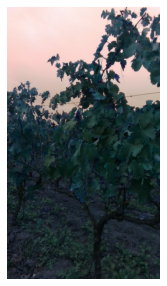

In [21]:
fnames_manual = get_image_files(path_manual_img)
lbl_names_manual = get_image_files(path_manual_lbl)

# open and show image
img_f = fnames_manual[30]
print(img_f)
img = PILImage.create(img_f)#,mode = "RGBA")
img.show(figsize=(10, 5))
img.split()

img1= Image.open(img_f)
#img1.split()

In [22]:
im2 = Image.open(str(path_manual_img)+'/FrameID000025_TimeStamp1626431635102.png')
im2.split()

(<PIL.Image.Image image mode=L size=720x1280 at 0x7FA5C11BAAC8>,
 <PIL.Image.Image image mode=L size=720x1280 at 0x7FA5C11BAB00>,
 <PIL.Image.Image image mode=L size=720x1280 at 0x7FA5C11BABA8>,
 <PIL.Image.Image image mode=L size=720x1280 at 0x7FA5C11BAB38>)

In [23]:
img.shape

(1280, 720)

In [24]:
img.split()

(<PIL.Image.Image image mode=L size=720x1280 at 0x7FA5C11BA0F0>,
 <PIL.Image.Image image mode=L size=720x1280 at 0x7FA5C11BA7B8>,
 <PIL.Image.Image image mode=L size=720x1280 at 0x7FA5C11BA9B0>)

In [25]:
print(get_y_fn(img_f))

DatasetDepth/Labels/train/FrameID001190_TimeStamp1634903343130.png


<AxesSubplot:>

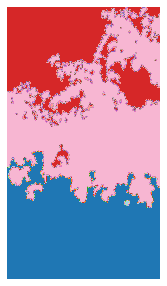

In [26]:
mask = PILMask.create(get_y_fn(img_f))#,mode = "RGBA")
mask.show(figsize=(10, 5), alpha=1)

In [27]:
#image = Image.open('DatasetUnet/Labels/train/FrameID001648_TimeStamp1634904126008.png')

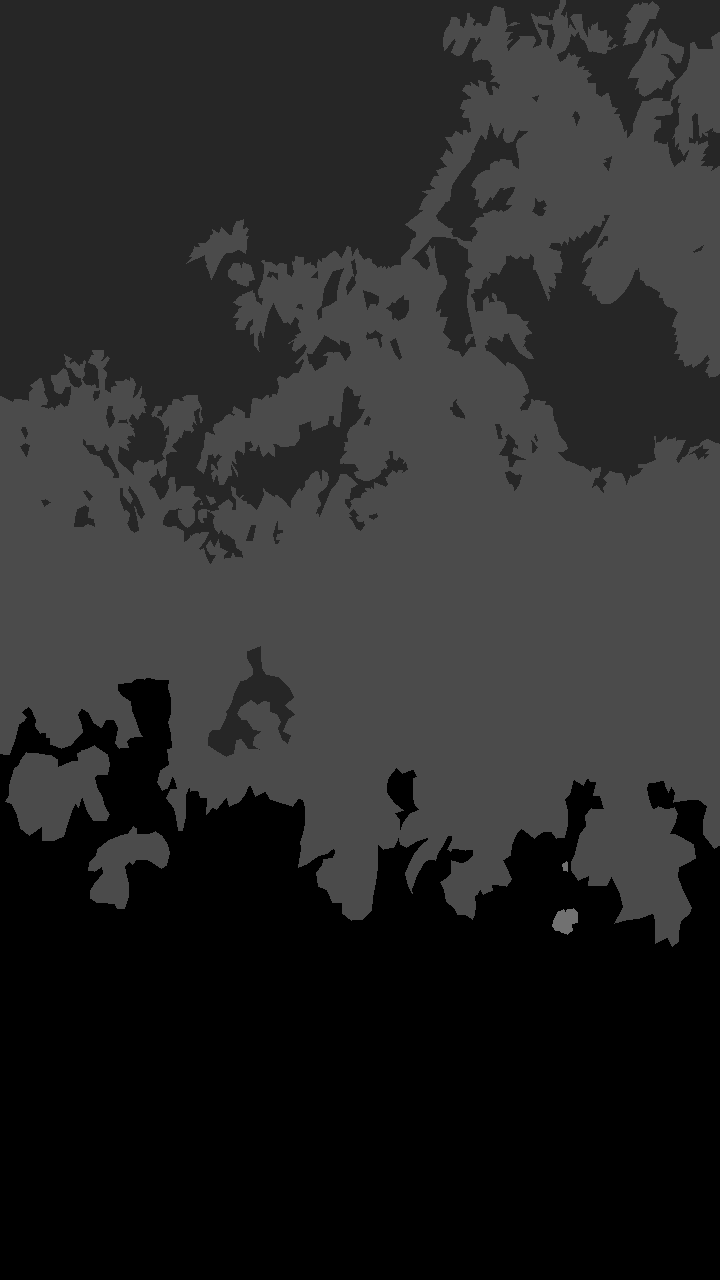

In [28]:
mask

In [29]:
mask1 = np.array(mask)

In [30]:
mask1[mask1==116]=0


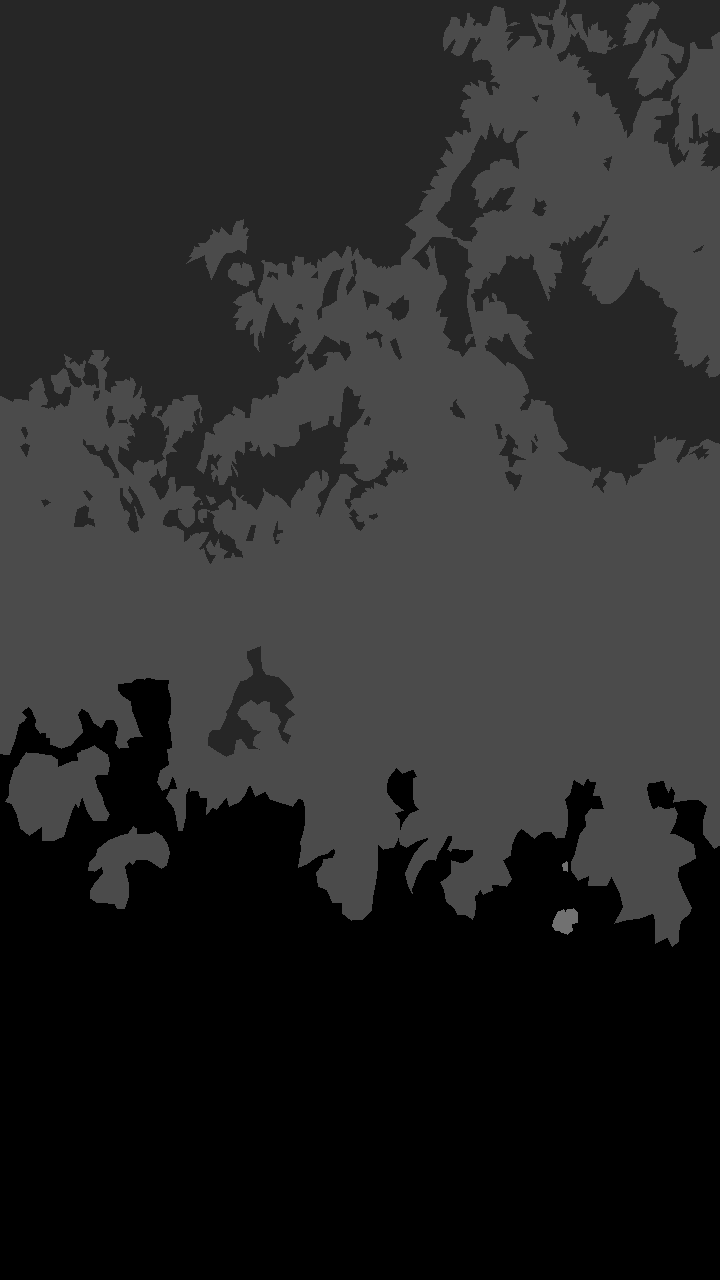

In [31]:
Image.fromarray(mask1)

In [32]:
np.unique(mask1)

array([  0,  38,  75, 113], dtype=uint8)

In [33]:
# for img_f in fnames_manual:
#     mask = PILMask.create(get_y_fn(img_f))
#     print(np.unique(np.array(mask)))

[  0  38  75 113]
[  0  38  75 113]
[  0  38  75 113]
[  0  38  75 113]
[  0  38  75 113]
[  0  38  75 113]
[  0  38  75 113]
[  0  38  75 113]
[ 0 42 86]
[  0  38  75 113]
[  0  38  75 113]
[  0  38  75 113]
[ 0 38 75]
[  0  38  75 113]
[  0  38  75 113]
[  0  38  75 113]
[  0  38  75 113]
[ 0 38 75]
[  0  38  75 113]
[  0  38  75 113]
[  0  38  75 113]
[  0  38  75 113]
[  0  38  75 113]
[  0  38  75 113]
[ 0 38 75]
[ 0 38 75]
[ 0 38 75]
[ 0 42 86]
[ 0 42 86]
[  0  42  86 116]
[  0  38  75 113]
[  0  38  75 113]
[  0  38  75 113]
[  0  38  75 113]
[  0  38  75 113]
[ 0 38 75]
[ 0 42 86]
[  0  38  75 113]
[ 0 42 86]
[ 0 38 75]
[  0  38  75 113]
[ 0 38 75]
[  0  38  75 113]
[ 0 38 75]
[  0  38  75 113]
[  0  38  75 113]
[  0  38  75 113]
[ 0 38 75]
[  0  38  75 113]
[  0  38  75 113]
[  0  38  75 113]
[  0  38  75 113]
[  0  38  75 113]
[ 0 38 75]
[  0  38  75 113]
[  0  38  75 113]
[  0  38  75 113]
[  0  38  75 113]
[  0  38  75 113]
[  0  38  75 113]
[  0  38  75 113]
[  0  38  75 1

In [36]:
bs = 4

In [37]:
codes

array(['Background', 'Cannopy', 'Grape'], dtype='<U10')

In [38]:
def my_get_items(folders,path):
    return (get_image_files(path))

In [39]:
def get_files(path, extensions=None, recurse=True, folders=None, followlinks=True):
    "Get all the files in `path` with optional `extensions`, optionally with `recurse`, only in `folders`, if specified."
    path = Path(path)
    folders=L(folders)
    extensions = setify(extensions)
    extensions = {e.lower() for e in extensions}
    if recurse:
        res = []
        for i,(p,d,f) in enumerate(os.walk(path, followlinks=followlinks)): # returns (dirpath, dirnames, filenames)
            if len(folders) !=0 and i==0: d[:] = [o for o in d if o in folders]
            else:                         d[:] = [o for o in d if not o.startswith('.')]
            if len(folders) !=0 and i==0 and '.' not in folders: continue
            res += _get_files(p, f, extensions)
    else:
        f = [o.name for o in os.scandir(path) if o.is_file()]
        res = _get_files(path, f, extensions)
    return L(res)

In [40]:
def get_image_filesA(path, recurse=True, folders=None):
    "Get image files in `path` recursively, only in `folders`, if specified."
    return get_files(path, extensions=image_extensions, recurse=recurse, folders=folders, mode='RGBA')

In [41]:
get_items= get_image_files
get_items

<function fastai.data.transforms.get_image_files(path, recurse=True, folders=None)>

In [42]:
manual = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=partial(get_image_files,folders=['train','test']),
                   get_y=get_y_fn,
                   splitter=FuncSplitter(ParentSplitter),
                   item_tfms=[Resize((480,640)), TargetMaskConvertTransform(), transformPipeline],#((480,640))
                   batch_tfms=Normalize.from_stats(*imagenet_stats))
                   #batch_tfms=[*aug_transforms(size=256,max_warp=0), 
                   #Normalize.from_stats(*imagenet_stats)])
#manual.summary(path_images)
#dls = manual.dataloaders(path_images,bs=bs)
#dls.show_batch(vmin=0,vmax=1,figsize=(12, 9))
dls = manual.dataloaders(path_images, bs=4)

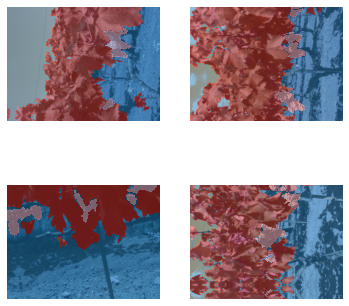

In [47]:
dls.show_batch()

In [46]:
get_y_fn = lambda x: Path(str(x).replace("Images","Labels").replace("color","gt").replace(".jpg",".png"))

In [44]:
# dblock = DataBlock( blocks = ( ImageBlock ,  MaskBlock(codes)),
#                    get_items= get_image_files,
#                    get_y=get_y_fn)
# dls = dblock.datasets(path_images/'train')
# img =dls.train[0][0]
# #img

In [45]:
#files = get_image_files(path_manual_img)
# len(files)
# img = files[0]


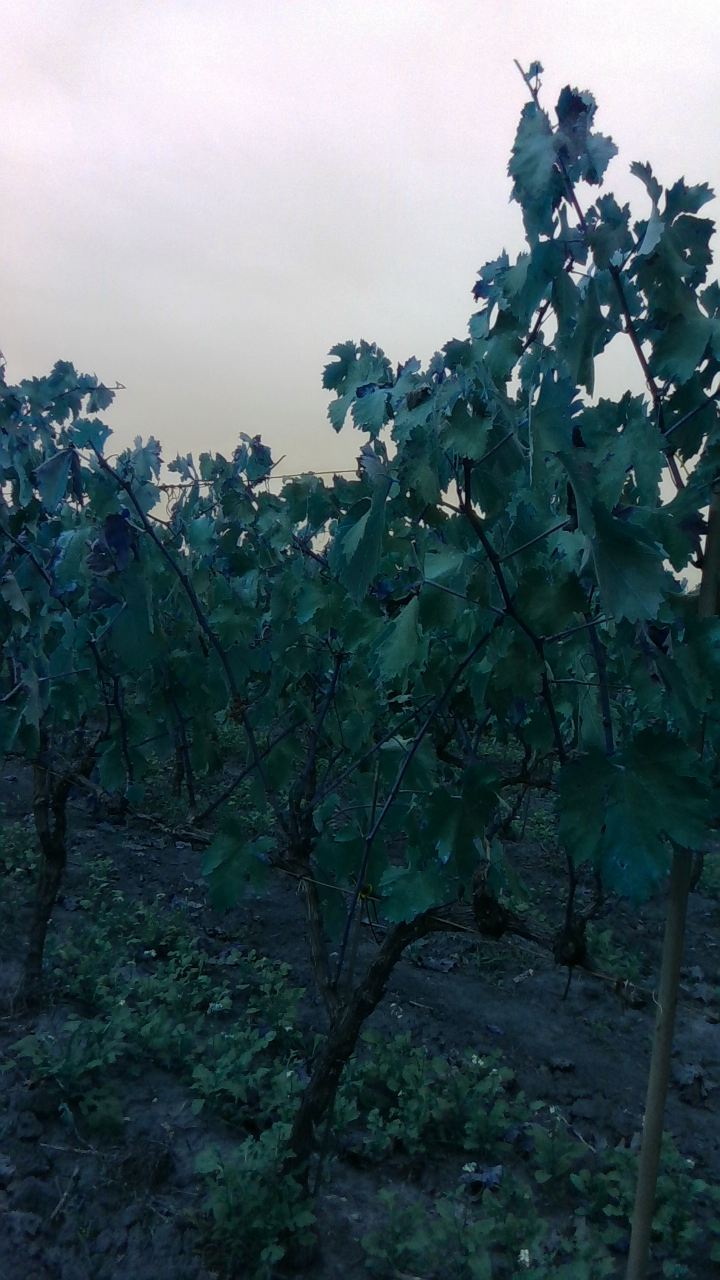

In [44]:
img

In [45]:
# im3 = Image.open(img)
# im3.split()

In [46]:
#x,mask=dls.one_batch()

# 

# Unet

In [68]:
model = smp.DeepLabV3Plus(
    encoder_name="resnext50_32x4d",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=3,                      # model output channels (number of classes in your dataset)
)

In [69]:
learn = Learner(dls,model,metrics=[background,cannopy,grape,msa]).to_fp16()

SuggestedLRs(valley=0.0002754228771664202)

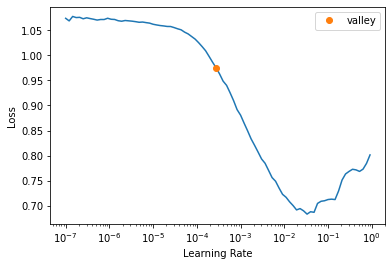

In [70]:
learn.lr_find()

Better model found at epoch 0 with valid_loss value: 0.9325869083404541.


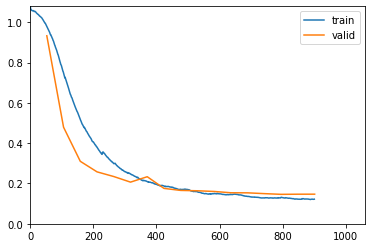

Better model found at epoch 1 with valid_loss value: 0.479064404964447.
Better model found at epoch 2 with valid_loss value: 0.309897780418396.
Better model found at epoch 3 with valid_loss value: 0.2575773596763611.
Better model found at epoch 4 with valid_loss value: 0.23441694676876068.
Better model found at epoch 5 with valid_loss value: 0.2066628634929657.
Better model found at epoch 7 with valid_loss value: 0.17557018995285034.
Better model found at epoch 8 with valid_loss value: 0.16555121541023254.
Better model found at epoch 9 with valid_loss value: 0.16379836201667786.
Better model found at epoch 10 with valid_loss value: 0.16037292778491974.
Better model found at epoch 11 with valid_loss value: 0.1538846790790558.
Better model found at epoch 12 with valid_loss value: 0.1535397619009018.
Better model found at epoch 13 with valid_loss value: 0.1496088206768036.
Better model found at epoch 14 with valid_loss value: 0.1460864096879959.
No improvement since epoch 14: early stoppi

In [71]:
fname="deeplab-depth-Resnext"

callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(20, slice(1e-5,1e-4),cbs=callbacksFitBeforeUnfreeze)

In [72]:
#learn.load("unet-before-unfreeze")

learn.validate()

(#5) [0.1460864096879959,0.9704760909080505,0.8115000128746033,0.9533945918083191,0.9482930302619934]

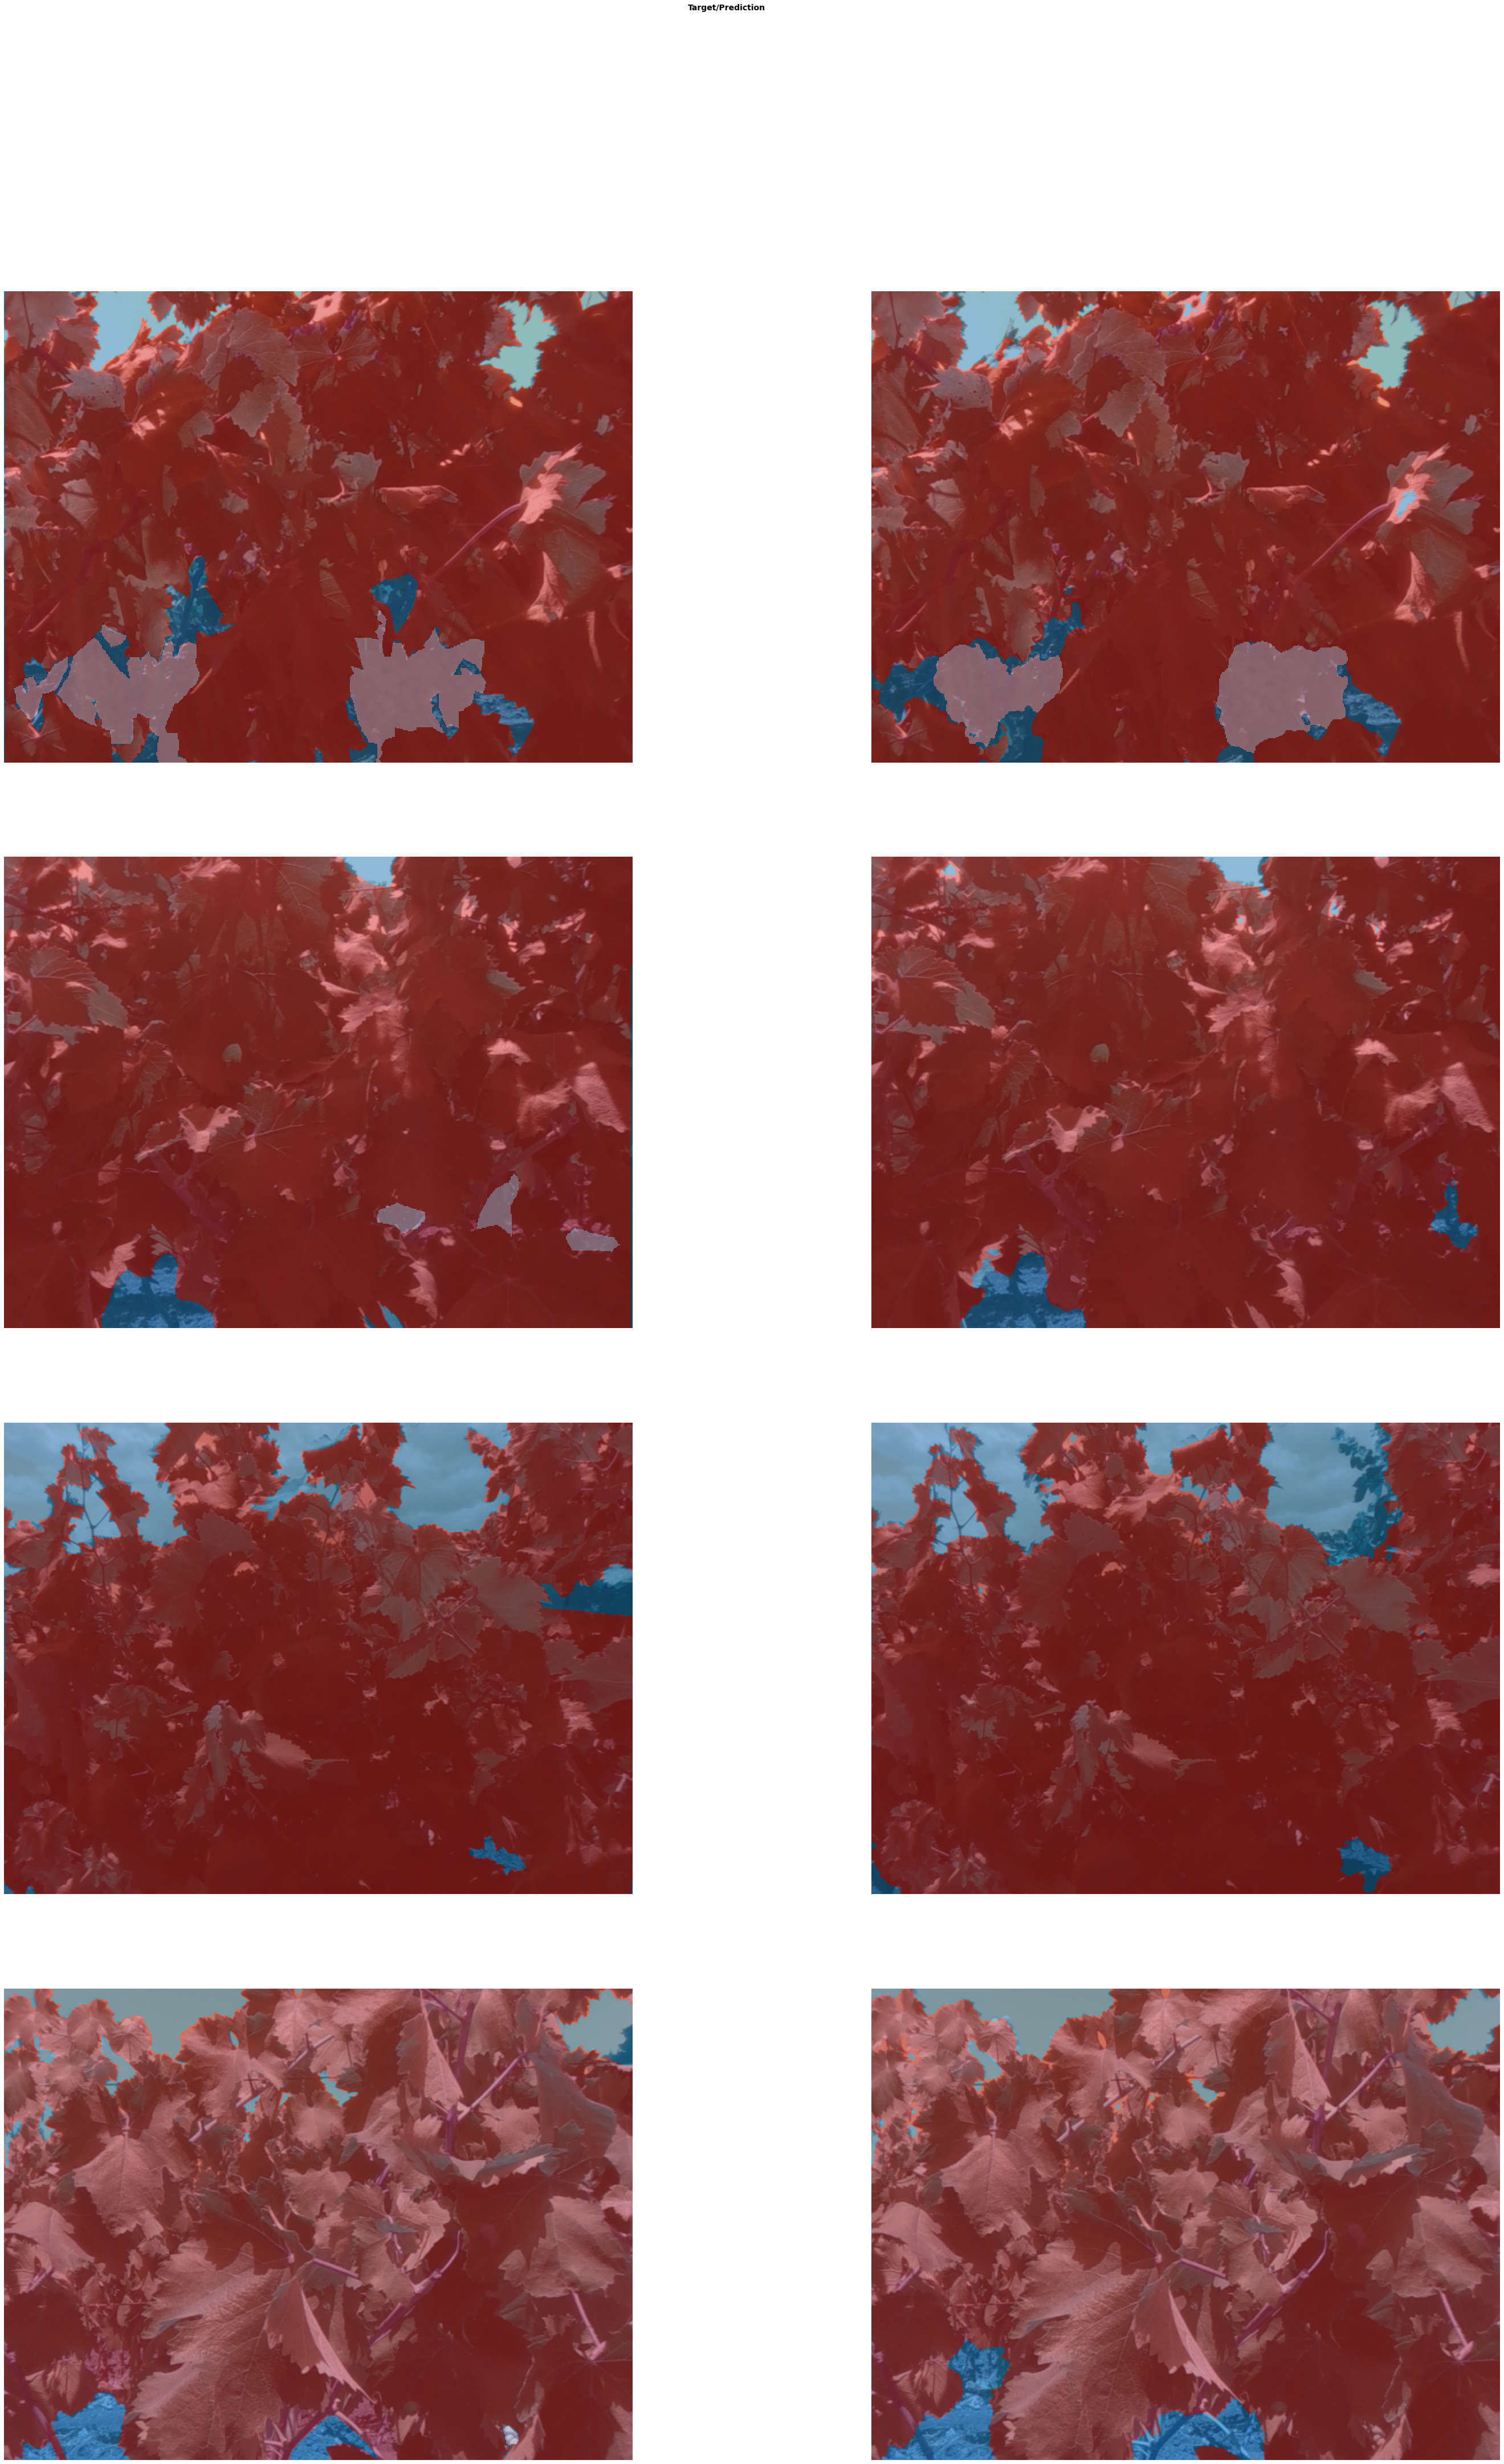

In [73]:
learn.show_results(figsize=(50,70))